# Курсовой проект. Прогнозирование цен на квартиры.

##### Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

### Подключаем необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Подключаем необходимые скрипты

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Указываем пути и загружаем датасеты Train.csv и Test.csv 

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

#### Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


### Просмотр информации о тренировочном датафрейме. Привидение типов.

In [7]:
train_df.info() # здесь понимаем, что нужно будет заполнить  недостающие значения LifeSquare и Healthcare_1.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Воспользуемся функцией reduce_mem_usage для приведения типов

In [8]:
train_df = reduce_mem_usage(train_df)
train_df.tail()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250
9999,7202,94,1.0,35.815475,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.625000


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Удаляем столбец Id, так как не несет смысловой нагрузки.   
        

In [10]:
train_df.drop('Id', axis = 1, inplace = True)

Cтобцу DistrictId присвоим качественный тип 'category'
- преобразование 0 в методе transf_emiss класса Preparing

### Просмотр описания датафрейма.

In [11]:
train_df.describe()[1:] # описание количественных показателей.

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
mean,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### Визуализация. Гистограмма распределения целевой переменной Price.

In [12]:
target_mean = round(train_df['Price'].mean(), 2) # среднее значение целевого признака
target_median = train_df['Price'].median() # медиана

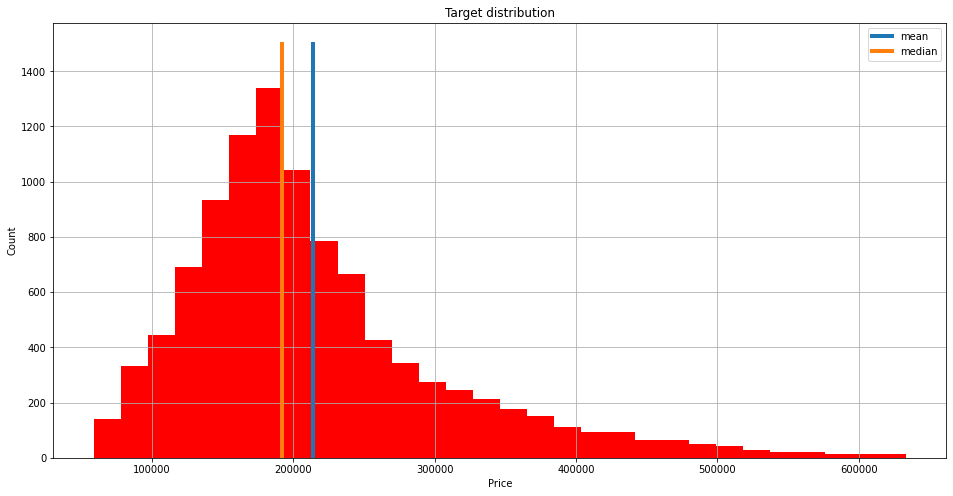

In [13]:
plt.figure(figsize=(16, 8))


y = np.linspace(0, 1500)
plt.plot([target_mean]*50, y, label='mean', linewidth=4)
plt.plot([target_median]*50, y, label='median', linewidth=4)

train_df['Price'].hist(bins = 30 , color='red')
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.legend()
plt.show()

### Матрица корреляции.

Визуализируем степень зависимости разных признаков друг от друга c помощью матрицы коррелции. Нас интересует последний столбец,
зависимость целевого значения Price от признаков. Видим максимальную корреляцию с площадью Square и количеством комнат Rooms. Эти признаки необоходимо обработать в первую очередь.

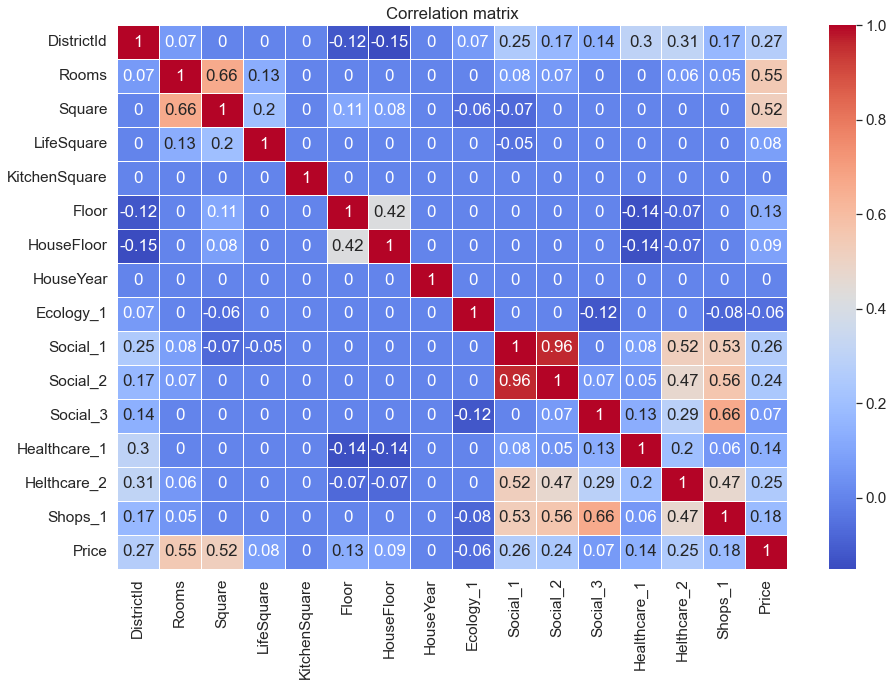

In [14]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.05] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Обработка пропусков.

Пропущенных значения LifeSquare и Healthcare_1. Заполним их медианами. 
- преобразование 1 в методе transf_emiss класса Preparing

### Обработка выбросов.

#### Rooms

Есть квартиры с количеством комнат равным 0, и несколько квартир с большим показателем комнат (> 5).
Будем считать их выбросами.
Заменим данные значения 25% и 75% квартилями соответственно. 
- преобразование 2 в методе transf_emiss класса Preparing

In [15]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

В итоге получили тренировочный и тестовый сеты с нормальным разбросом по количеству комнат Rooms от 1 до 5.

#### Square, LifeSquare

Рассмотрим диаграмму разброса площади Square.

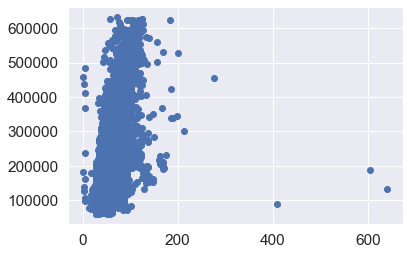

In [16]:
plt.scatter(train_df['Square'],  train_df['Price'])

plt.show()

In [17]:
train_df.sort_values(by='Square').head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7470,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.828125
4496,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.781250
9869,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
8572,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.593750
161,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.187500
8805,27,1.0,4.380726,40.805836,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.718750
328,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.062500
4800,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.500000
5009,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.265625
9067,1,3.0,4.823679,79.767967,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.687500


Различными наблюдениями определили некоторые несоответствия в колонках Square и LifeSquare:
- выбросы в значениях Square больше  200 или меньше 10.
- выбросы в значениях LifeSquare меньше  10.
- LifeSquare больше Square

Значения  Square больше 200 или меньше 10 заменяются медианами и соответствующие им значения LifeSquare тоже заменяется медианами.
Там где значения LifeSquare больше Square или значения LifeSquare < 10 они заменяются средней долей LifeSquare в Square умноженной на соответствующий Square.

- преобразование 3 в методе transf_emiss класса Preparing


#### KitchenSquare

In [18]:
train_df.sort_values(by='KitchenSquare').tail(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
5273,42,1.0,38.071693,19.723547,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.031250
3956,96,3.0,78.445679,47.146755,75.0,9,12.0,1977,0.041116,B,B,53,14892,4,NaN,1,4,B,290354.468750
2831,54,2.0,79.810532,79.578964,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.718750
2785,27,1.0,38.220257,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960938
2454,72,3.0,97.490677,99.323555,96.0,22,25.0,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.968750
7733,58,3.0,116.405693,113.109650,112.0,3,3.0,2016,0.437885,B,B,23,5735,3,1084.0,0,5,B,296165.937500
5002,62,3.0,114.734474,112.589081,112.0,3,3.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.531250
286,27,3.0,123.430069,125.806984,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.843750
6505,81,1.0,32.276665,19.278395,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.554688
9520,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375


KitchenSquare выбросы более 0.995 квантиля приравниваются медиане, значения < 3 приравниваются 3
- преобразование 4 в методе transf_emiss класса Preparing

#### Floor, HouseFloor

In [19]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [20]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

Проверяем на неверные значения, где этаж квартиры больше этажности дома.

In [21]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor']].shape

(1825, 19)

In [22]:
test_df.loc[train_df['Floor'] > train_df['HouseFloor']].shape

(889, 19)

Меняем 0-ые этажи на 1 и задаем случайный этаж в диапазаоне этажности дома, где этаж квартиры оказывался выше максимально этажа дома.
- преобразование 5 в методе transf_emiss класса Preparing

#### HouseYear

In [23]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

Года постройки больше 2022 приравниваем к 2022.
- преобразование 6 в методе transf_emiss класса Preparing

### Добавление новых признаков

- Добавляем столбец PricePerMeter с ценой квадратного метра на каждую квартиру.
- Группируем по DistrictId и значение принимается по средней цене квадратного метра в районе.
- Удаляем столбец PricePerMeter.
- Добавляем столбец DistrictPriceMeter где будет храниться данные о средней стоимости квадратного метра в районе DistrictId.

In [24]:
train_df['PricePerMeter'] = train_df['Price'] / train_df['Square']
group_distr = train_df.groupby('DistrictId')['PricePerMeter'].mean()
train_df.drop('PricePerMeter', axis = 1, inplace = True)
train_df['DistrictPriceMeter'] = [group_distr[x] for x in train_df['DistrictId']]

Номера DistrictId test_df которых нет в train_df

In [25]:
num_test_unique = np.setdiff1d(test_df['DistrictId'].unique(),train_df['DistrictId'].unique()).tolist()
num_test_unique

[198, 203, 204, 206, 210, 211, 212]

Создаем массив где индексы из списка выше, а значения - медианы по средней цене квадратного метра среди всех районов

In [26]:
num_test_unique_series = pd.Series(group_distr.median(), index=num_test_unique)
num_test_unique_series

198    4666.27002
203    4666.27002
204    4666.27002
206    4666.27002
210    4666.27002
211    4666.27002
212    4666.27002
dtype: float32

Добавляем полученный массив к group_distr, где указаны средние цены за квадратный метр по районам.

In [27]:
group_distr = group_distr.append(num_test_unique_series)
group_distr.tail(10)

207    5550.678223
208    8005.604492
209    4176.437500
198    4666.270020
203    4666.270020
204    4666.270020
206    4666.270020
210    4666.270020
211    4666.270020
212    4666.270020
dtype: float32

Наполняем тестовые данные столбцом цены квадратного метра по районам DistrictPriceMeter

In [28]:
test_df['DistrictPriceMeter'] = [group_distr[x] for x in test_df['DistrictId']]

### Создание класса предобработки данных

In [29]:
class Preparing:
    
    
    def fit_emiss(self, data):
        
       
        ''' расчет медианы, 0.25 и 0.75 квантилей(Rooms)'''
        self.emiss_med_R = data['Rooms'].median()
        self.emiss_q75_R = data['Rooms'].quantile(0.75)
        self.emiss_q25_R = data['Rooms'].quantile(0.25)
        
        ''' расчет медиан (Square, LifeSquare), расчет LifeSquare по средней доле в Square '''
        self.emiss_med_S = data['Square'].median()
        self.emiss_med_LS = data['LifeSquare'].median()
        self.emiss_meanLStoS = (data['LifeSquare'] / data['Square']).mean() *  data['Square']
        
        ''' расчет медианы (KitchenSquare)'''
        self.emiss_med_KS = data['KitchenSquare'].median()



    def transf_emiss(self, data):
        
        # 0
        data['DistrictId'] = data['DistrictId'].astype(dtype='category')
        
        # 1
        data['LifeSquare'] = data['LifeSquare'].fillna(data['LifeSquare'].median())
        data['Healthcare_1'] = data['Healthcare_1'].fillna(data['Healthcare_1'].median())
                
        # 2
        data.loc[(data['Rooms'] >= 6), 'Rooms'] = self.emiss_q75_R
        data.loc[(data['Rooms'] == 0), 'Rooms'] = self.emiss_q25_R
        
        # 3
        data.loc[(data['Square'] > 200) | (data['Square'] < 10), ['Square', 'LifeSquare']] = [self.emiss_med_S, self.emiss_med_LS]
        data.loc[(data['Square'] < data['LifeSquare']) | (data['LifeSquare'] < 10), 'LifeSquare'] = self.emiss_meanLStoS 
        
        # 4
        data.loc[data['KitchenSquare'] > data['KitchenSquare'].quantile(.995), 'KitchenSquare'] = self.emiss_med_KS
        data.loc[data['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # 5 
        data.loc[data['HouseFloor'] == 0, 'HouseFloor'] = 1
        floor_out = data.loc[data['Floor'] > data['HouseFloor']].index    
        data.loc[floor_out, 'Floor'] = data.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(1, x))
    
        # 6
        data.loc[data['HouseYear'] > 2022, 'HouseYear'] = 2022
        
        # 7 пример перевода количественных признаков в качественные, не использовал 
        
        # data.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        # data.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        # data.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

Теперь применим наши методы класса Preparing к тренировочному и тестовым сетам .
ВАЖНО! Метод fit_emiss применяем только к тренировочному сету, а на основании этих значений преобразуем тестовый сет.

In [30]:
prep = Preparing()
prep.fit_emiss(train_df)

prep.transf_emiss(train_df)
prep.transf_emiss(test_df)

In [31]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictPriceMeter
0,27,3.0,115.027313,32.781261,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,900.0,0,0,B,305018.875000,2912.252197
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875,3738.867432
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750,3522.839600
3,1,1.0,40.409908,32.781261,3.0,10,22.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,168106.000000,3522.839600
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,900.0,0,6,B,343995.093750,4194.537109


Взглянем на получившиеся распределения признаков LifeSquare и Square. Логарифмируем по оси 'y' для лучшего отображения.

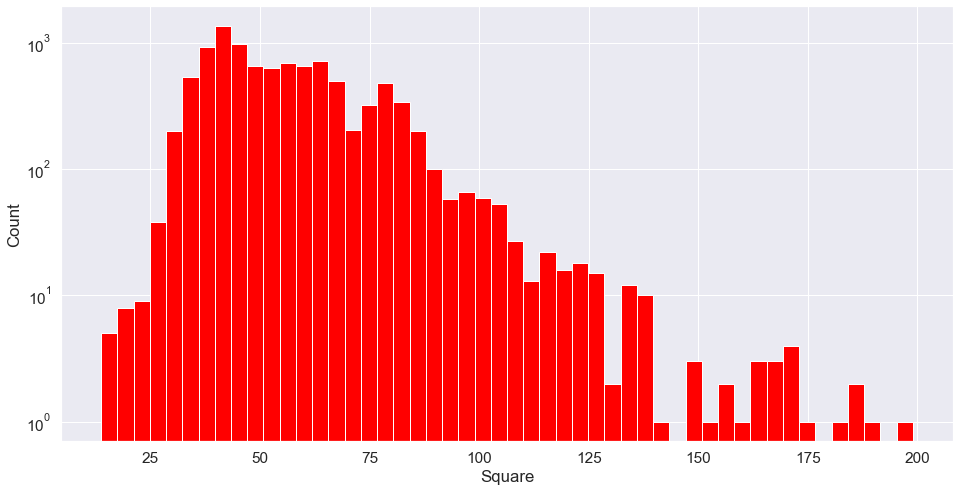

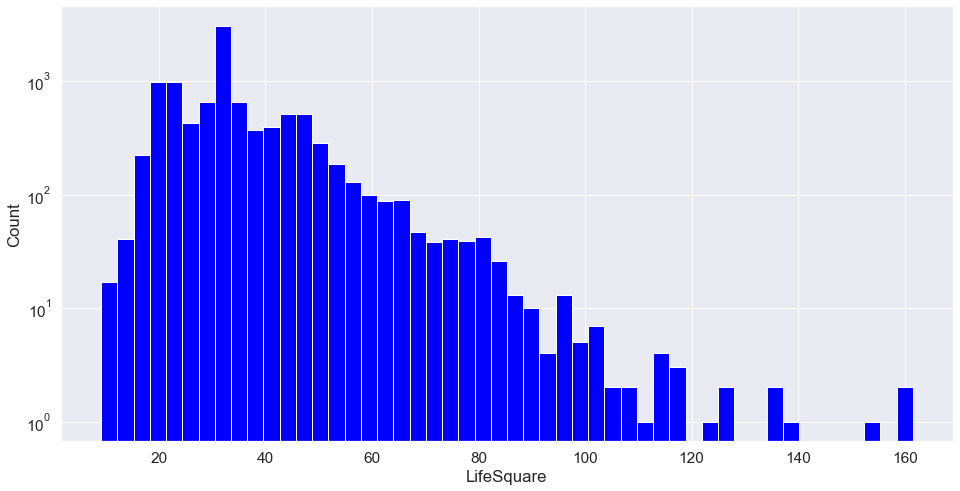

In [32]:
plt.figure(figsize=(16, 8))

train_df['Square'].hist(bins = 50 , color='red')
plt.yscale(value="log")

plt.ylabel('Count')
plt.xlabel('Square')

plt.figure(figsize=(16, 8))

train_df['LifeSquare'].hist(bins = 50 , color='blue')
plt.yscale(value="log")

plt.ylabel('Count')
plt.xlabel('LifeSquare')

plt.show()

### Стандартизация и моделирование.

#### Стандартизация признаков

Стандартизируем все количественные признаки и исключаем целевой Price 

In [33]:
feature_names = train_df.select_dtypes(exclude = 'category').columns.tolist()
feature_names.remove('Price')
feature_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'DistrictPriceMeter']

In [34]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(train_df[feature_names])

In [35]:
train_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

#### Моделирование

In [36]:
y = train_df['Price']

In [37]:
X = train_df[feature_names]

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=42)

In [39]:
# оптимальные параметры для RandomForestRegressor получили из GridSearchCV с помощью best_params_

#parameters = {
#   'min_samples_leaf': np.arange(5, 11),
#   'max_depth': np.arange(5, 11),
#   'n_estimators': [100, 150, 200, 250],
#}

#clf = GridSearchCV(
#    estimator=RandomForestRegressor(),
#    param_grid=parameters,
#    scoring='r2',
#    cv=5,
#)

#clf.fit(X, y)
#clf.best_params_  
# {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}

In [40]:
# model = RandomForestRegressor(criterion='mse',
#                                 max_depth=10, # глубина дерева  
#                                 min_samples_leaf=5, # минимальное кол-во наблюдений в листе дерева
#                                 random_state=42,
#                                 n_estimators=100  # кол-во деревьев
#                                 )

In [41]:
model = GradientBoostingRegressor(criterion='mse',
                                   max_depth=6,
                                   min_samples_leaf=50,
                                   random_state=42,  
                                   n_estimators=2250, 
                                   max_features='sqrt', 
                                   loss='huber', 
                                   learning_rate=0.025)

# Та модель которая показывала лучшие результаты на Kaggle 0.75187 

In [42]:
model

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=42)

In [43]:
model.fit(X_train, y_train)
y_train_preds = model.predict(X_train)

In [44]:
r2(y_train, y_train_preds)

0.8615053917430284

In [45]:
y_valid_preds = model.predict(X_valid)

In [46]:
# Метрика R2
r2(y_valid, y_valid_preds)

0.7615473047600311

In [47]:
# Метрика RMSE
np.sqrt(mse(y_valid, y_valid_preds))

46853.60894491534

Train R2:	0.862
Test R2:	0.762


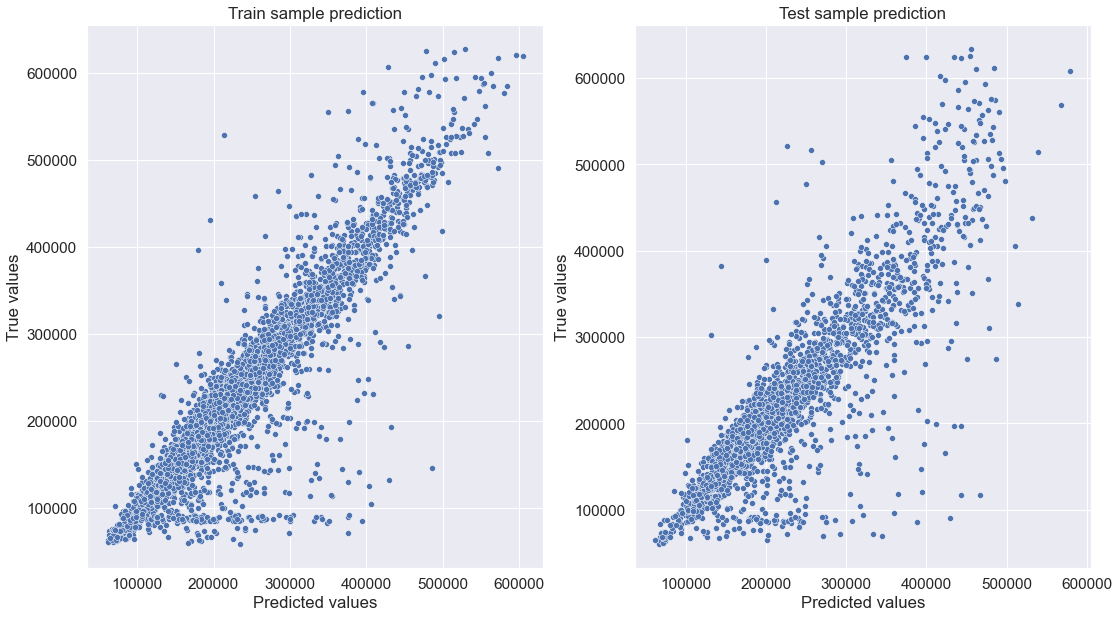

In [48]:
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

### Тестовое задание

In [49]:
model.fit(X, y)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=42)

In [50]:
stand_features = scaler.transform(test_df[feature_names])
test_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

In [51]:
pred = pd.DataFrame(model.predict(test_df[feature_names]), columns=['Price'])

In [52]:
pred.insert(0, 'Id', test_df['Id'])

In [53]:
pred.tail()

,Id,Price
4995,10379,174760.810775
4996,16138,408978.008493
4997,3912,154329.129117
4998,5722,193304.707542
4999,11004,301416.343784


In [54]:
pred.to_csv('Simakov_predict.csv', index=False)